# Цель работы. 
Подготовить собственный набор данных. Обучить сверточную нейронную сеть на основе собственного набора данных. 
# Часть 1
Подготовка данных

In [99]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [100]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/face.zip',"r") as zip_ref:
    zip_ref.extractall() 

In [101]:
input_folder = '../content/face'

In [102]:
import glob
import pathlib
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
#Автоматическая настройка времени выполнения tf.data
AUTOTUNE = tf.data.experimental.AUTOTUNE
#Присваиваем переменную для нашего пути
data_root = pathlib.Path(input_folder)

In [103]:
#Просматриваем названия все директории, наши будущие классы
for item in data_root.iterdir():
    print(item)

../content/face/woman
../content/face/man


In [104]:
import random
#Получим все пути наших картинок
all_image_paths = list(data_root.glob('*/*'))

#Определим в список все пути наших картинок
all_image_paths = [str(path) for path in all_image_paths]

#Перемешаем в случайном порядке
random.shuffle(all_image_paths)

#Получим общее кол-во наших картинок
image_count = len(all_image_paths)
image_count

1961

In [105]:
all_image_paths[:10]

['../content/face/man/face_71.jpg',
 '../content/face/woman/face_50.jpg',
 '../content/face/man/face_1165.jpg',
 '../content/face/man/face_836.jpg',
 '../content/face/man/face_926.jpg',
 '../content/face/woman/face_52.jpg',
 '../content/face/woman/face_1159.jpg',
 '../content/face/man/face_959.jpg',
 '../content/face/man/face_4.jpg',
 '../content/face/woman/face_429.jpg']

In [106]:
#Выведем в список все наши классы
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['man', 'woman']

In [107]:
#Присвоим индексы нашим классам
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'man': 0, 'woman': 1}

In [108]:
#Присвоим индекс каждого класса к каждой картинке относящиеся к этому классу
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

#Выведем последние 6 индекса
print("First 6 labels indices: ", all_image_labels[:6])

First 6 labels indices:  [0, 1, 0, 0, 0, 1]


In [109]:
img_path = all_image_paths[1]
img_path

'../content/face/woman/face_50.jpg'

In [110]:

#Сырые данные
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [111]:
#Преобразование в тензор изображения
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(155, 124, 3)
<dtype: 'uint8'>


In [112]:
#Установим размер для нашей модели
img_final = tf.image.resize(img_tensor, [102, 80])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(102, 80, 3)
0.0
1.0


In [113]:
#Функция декодирования и изменения размера для нашей модели
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image

In [114]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [115]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)


In [116]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [117]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

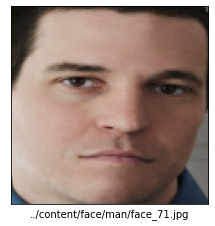

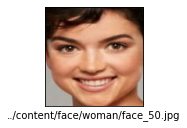

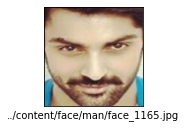

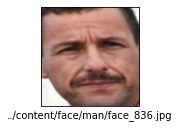

In [118]:

#Отобразим несколько преобразованных картинок
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(all_image_paths[n])
    plt.show()

In [119]:
#Соберем датасет меток
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [120]:
#Выведем метки
for label in label_ds.take(6):
    print(label_names[label.numpy()])

man
woman
man
man
man
woman


In [121]:
#Соберем набор данных с помощью метода zip
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [122]:
print(image_label_ds)

<ZipDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.int64)>


## Часть 2
Обучение модели


In [123]:
BATCH_SIZE = 32

# Установка размера буфера перемешивания, равного набору данных, гарантирует
# полное перемешивание данных.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` позволяет датасету извлекать пакеты в фоновом режиме, во время обучения модели.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>

In [124]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>

In [125]:
mobile_net = MobileNetV2(input_shape=(128, 128, 3), include_top=False)
mobile_net.trainable=False

In [126]:
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

In [127]:
image_batch, label_batch = next(iter(keras_ds))

In [128]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 4, 4, 1280)


In [129]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

In [130]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.02048682
max logit: 0.9795132

Shape: (32, 2)


In [131]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [132]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [133]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

62.0

In [134]:
model = model.fit(ds, epochs=15, steps_per_epoch=15)

Epoch 1/15
15/15 [==============================] - 6s 373ms/step - loss: 1.0016 - accuracy: 0.5396
Epoch 2/15
15/15 [==============================] - 5s 365ms/step - loss: 0.5758 - accuracy: 0.7417
Epoch 3/15
15/15 [==============================] - 6s 367ms/step - loss: 0.4591 - accuracy: 0.8021
Epoch 4/15
15/15 [==============================] - 6s 371ms/step - loss: 0.3907 - accuracy: 0.8396
Epoch 5/15
15/15 [==============================] - 6s 368ms/step - loss: 0.3256 - accuracy: 0.8687
Epoch 6/15
15/15 [==============================] - 5s 366ms/step - loss: 0.3427 - accuracy: 0.8521
Epoch 7/15
15/15 [==============================] - 6s 376ms/step - loss: 0.3261 - accuracy: 0.8604
Epoch 8/15
15/15 [==============================] - 6s 367ms/step - loss: 0.2656 - accuracy: 0.9021
Epoch 9/15
15/15 [==============================] - 6s 368ms/step - loss: 0.2483 - accuracy: 0.9062
Epoch 10/15
15/15 [==============================] - 6s 369ms/step - loss: 0.2657 - accuracy: 0.8958

In [139]:
print(model.history.keys())

dict_keys(['loss', 'accuracy'])


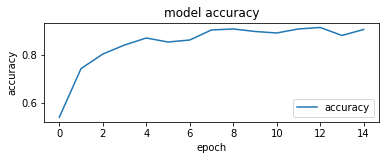

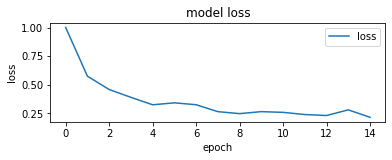

In [140]:
plt.subplot(211)  
plt.plot(model.history['accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['accuracy']) 
plt.show()

plt.subplot(212)  
plt.plot(model.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['loss'], loc='upper right') 
plt.show()

# Список литературы
[1] MobileNet: меньше, быстрее, точнее – https://habr.com/ru/post/352804/

[2] Transfer Learning Using Pretrained ConvNets – https://www.tensorflow.org/alpha/tutorials/images/transfer_learning

[3] Natural Images – https://www.kaggle.com/prasunroy/natural-images

[4] Load images with tf.data – https://www.tensorflow.org/alpha/tutorials/load_data/images
